# Анализ данных

Импортируем всякое для начала

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer

Сразу установим стиль, чтобы было с сеткой

In [2]:
sns.set_style("whitegrid")

Определяем путь к папке с данными

In [3]:
data_dir = os.path.join('..', 'data')

И читаем все данные в датафреймы

In [4]:
users_df = pd.read_csv(os.path.join(data_dir, 'users.tsv'), sep='\t')
history_df = pd.read_csv(os.path.join(data_dir, 'history.tsv'), sep='\t')
validate_df = pd.read_csv(os.path.join(data_dir, 'validate.tsv'), sep='\t')
validate_answers_df = pd.read_csv(os.path.join(data_dir, 'validate_answers.tsv'), sep='\t')

Посмотрим что у нас тут

In [5]:
users_df.head()

,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4


In [6]:
history_df

,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148
...,...,...,...,...
1147852,382,45.00,1,7871
1147853,360,33.35,1,7992
1147854,381,205.00,1,21516
1147855,383,37.50,1,8224


In [7]:
validate_df

,cpm,hour_start,hour_end,publishers,audience_size,user_ids
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1..."
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3..."
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5..."
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524..."
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2..."
...,...,...,...,...,...,...
1003,127.0,1095,1154,"2,7,12,15,16",368,"38,50,143,237,456,649,653,698,881,893,1100,127..."
1004,90.0,1052,1056,"2,21",484,"1,4,61,212,230,348,356,372,429,431,462,540,593..."
1005,122.0,1058,1063,"2,5",704,"1,23,29,104,136,176,201,206,250,269,355,403,44..."
1006,138.0,932,1169,"1,2,7",1210,"67,73,80,146,182,202,212,254,307,377,383,385,3..."


In [8]:
validate_answers_df

,at_least_one,at_least_two,at_least_three
0,0.0430,0.0152,0.0073
1,0.0130,0.0000,0.0000
2,0.0878,0.0135,0.0000
3,0.2295,0.1295,0.0727
4,0.3963,0.2785,0.2270
...,...,...,...
1003,0.0679,0.0408,0.0190
1004,0.0165,0.0000,0.0000
1005,0.0071,0.0000,0.0000
1006,0.3669,0.2628,0.2066


## history

Посмотрим что у нас по типам

In [9]:
history_df.dtypes

hour           int64
cpm          float64
publisher      int64
user_id        int64
dtype: object

На всякий случай переведем в Categorical, мб удобно будет

In [10]:
sorted_publishers = [str(publisher) for publisher in sorted(history_df['publisher'].unique())]

history_df['publisher'] = history_df['publisher'].apply(str)
history_df['publisher'] = pd.Categorical(history_df['publisher'], sorted_publishers)

history_df['user_id'] = history_df['user_id'].apply(str)

Мне показались странными hour_*

In [11]:
history_df['hour'].unique()

array([  10,    8,    7, ..., 1489, 1488, 1490], dtype=int64)

<Axes: xlabel='hour', ylabel='Count'>

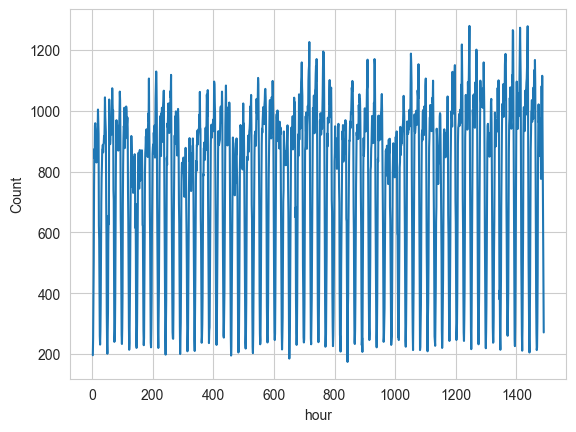

In [12]:
sns.histplot(data=history_df, x='hour', element='poly', discrete=True, fill=False)

Теперь понятно, можно брать нормальные часы через остаток от деления по модулю 24

Так и сделаем

In [13]:
history_df['hour_norm'] = history_df['hour'] % 24

sorted_hours = [str(hour) for hour in sorted(history_df['hour_norm'].unique())]

history_df['hour_norm'] = history_df['hour_norm'].apply(str)
history_df['hour_norm'] = pd.Categorical(history_df['hour_norm'], sorted_hours)

Посмотрим что сейчас получилось

<Axes: xlabel='hour_norm', ylabel='Count'>

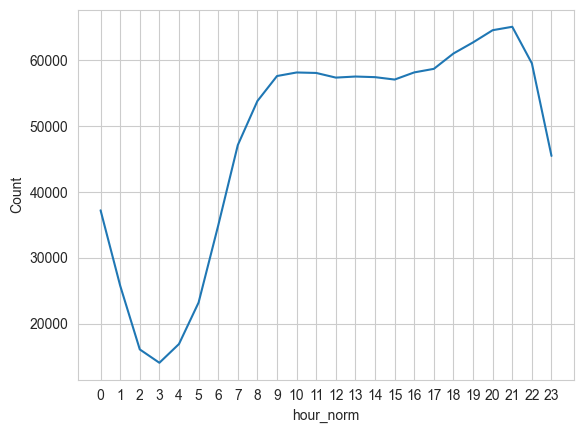

In [14]:
sns.histplot(data=history_df, x='hour_norm', bins=24, element='poly', discrete=True, fill=False)

Стало понятнее  
Сразу видно, что есть пиковые часы

Посмотрим справедливо ли это для разных площадок

<Axes: xlabel='hour_norm', ylabel='Count'>

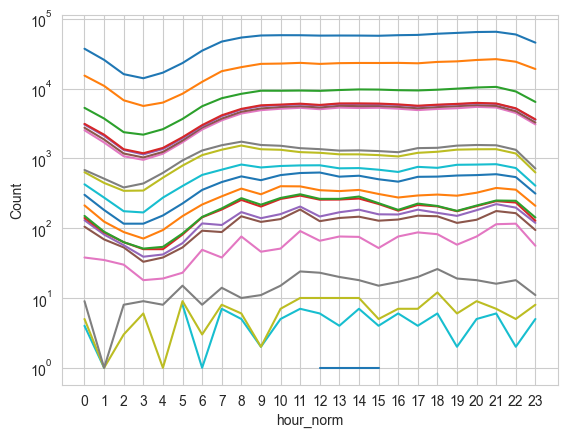

In [15]:
pallete = sns.color_palette("tab10", 21)
sns.histplot(data=history_df, x='hour_norm', bins=24, element='poly', discrete=True, fill=False, hue='publisher', multiple='stack', log_scale=(False, True), legend=False, palette=pallete)

Ну в целом, да, справедливо  
Попробуем в будущем это использовать

А что по распределению реклам по площадкам

<Axes: xlabel='publisher', ylabel='Count'>

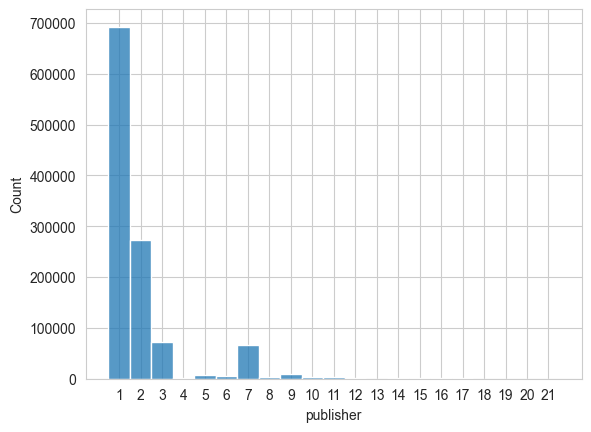

In [16]:
sns.histplot(data=history_df, x='publisher')

Неравномерное, сильно  
Возможно это тоже можно использовать

А распределение cpm по площадкам?

<Axes: xlabel='publisher', ylabel='cpm'>

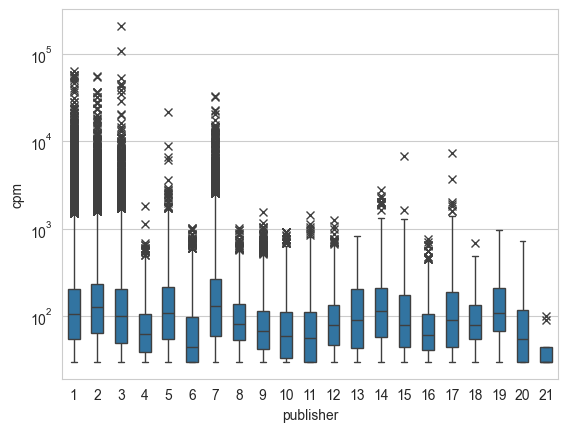

In [17]:
sns.boxplot(data=history_df, x='publisher', y='cpm', width=0.5, log_scale=True, flierprops={'marker': 'x'})

Нууу, не так интересно, еще и выбросов много

In [18]:
history_df['cpm'].describe()

count    1.147857e+06
mean     1.864043e+02
std      4.557257e+02
min      3.000000e+01
25%      5.500000e+01
50%      1.100000e+02
75%      2.100000e+02
max      2.090540e+05
Name: cpm, dtype: float64

Попробуем почистить немного

In [19]:
cpm = history_df[['cpm', 'publisher', 'hour_norm']]
cpm = cpm[cpm['cpm'] < cpm['cpm'].quantile(0.95)]
cpm = cpm[cpm['cpm'] > cpm['cpm'].quantile(0.05)]

<Axes: xlabel='publisher', ylabel='cpm'>

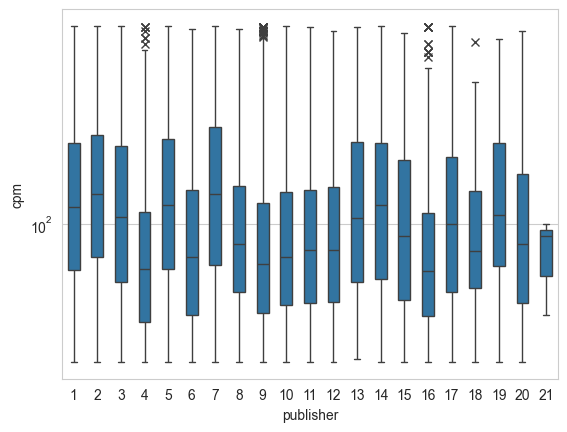

In [20]:
sns.boxplot(data=cpm, x='publisher', y='cpm', width=0.5, log_scale=True, flierprops={'marker': 'x'})

Так по-лучше, но вряд ли это распределение будет сильно значимо для нас

Может распределение cpm по часам будет интереснее?

<Axes: xlabel='hour_norm', ylabel='cpm'>

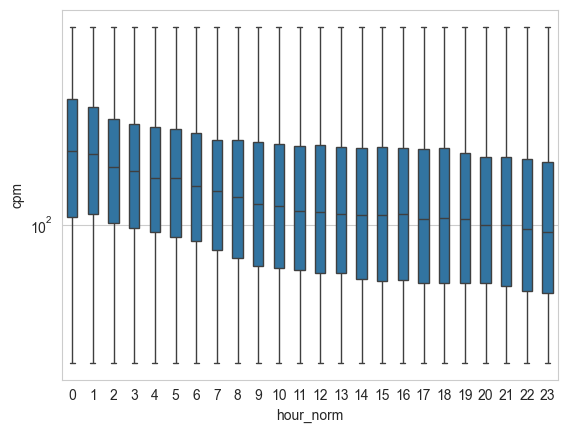

In [21]:
sns.boxplot(data=cpm, x='hour_norm', y='cpm', width=0.5, log_scale=True, flierprops={'marker': 'x'})

Не сильно

А сами то cpm как распределены?

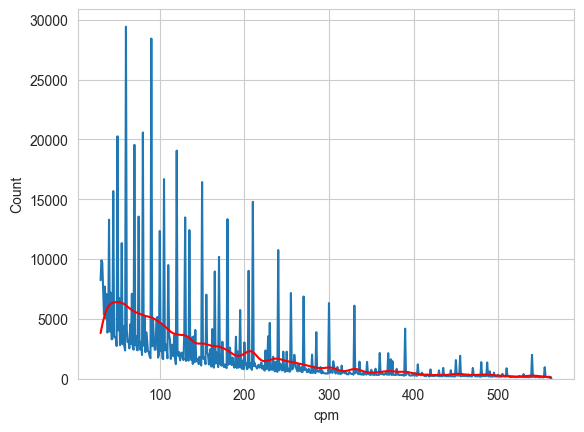

In [22]:
ax = sns.histplot(data=cpm, x='cpm', element='poly', discrete=True, fill=False, kde=True)
ax.lines[1].set_color('red')

О, как в видео от VK, логнорм - норм и всё такое

На всякий случай убедимся в этом более подробно

<Axes: xlabel='cpm', ylabel='Density'>

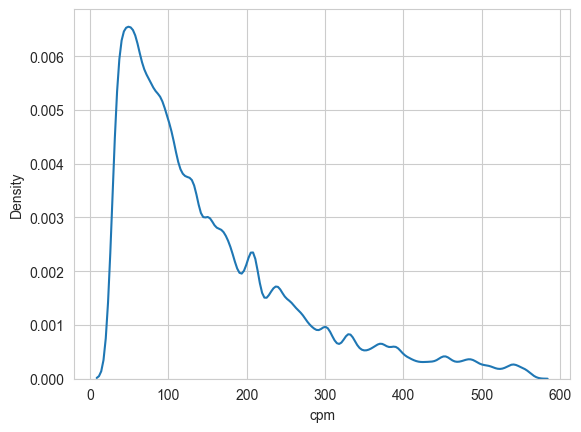

In [23]:
sns.kdeplot(data=cpm, x='cpm')

<Axes: xlabel='cpm', ylabel='Proportion'>

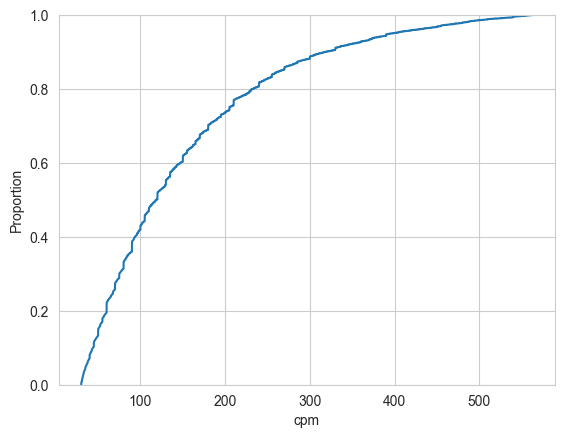

In [24]:
sns.ecdfplot(data=cpm, x='cpm')

Действительно похоже на логнорм

Поробуем привести это в более нормальный вид

In [25]:
log_transformer = FunctionTransformer(np.log1p)

Логарифмируем cpm в таблице истории

In [26]:
cpm['cpm_log'] = log_transformer.transform(cpm['cpm'])

<Axes: xlabel='cpm_log', ylabel='Density'>

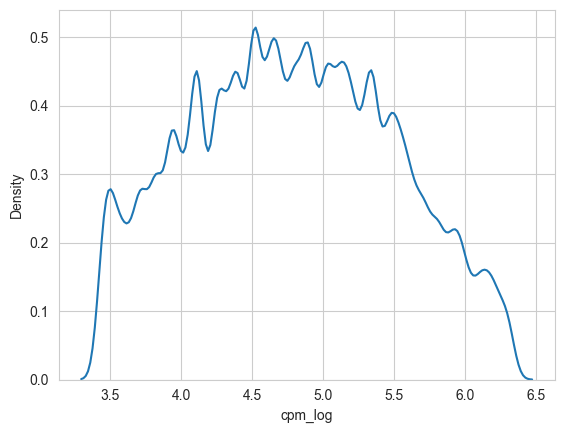

In [27]:
sns.kdeplot(data=cpm, x='cpm_log')

Это визуально более похоже на нормальное распределение

Проведем аналогичные действия с таблицей validate

<Axes: xlabel='cpm', ylabel='Density'>

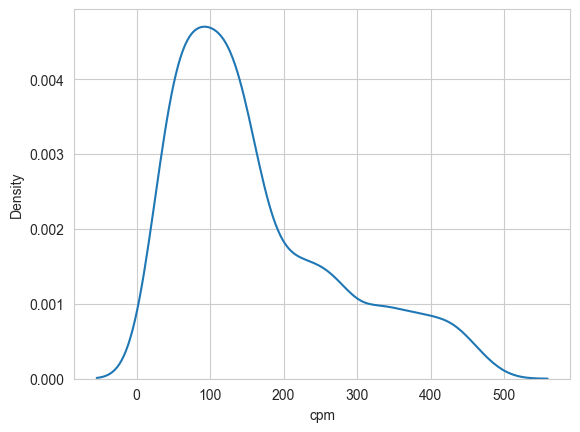

In [28]:
sns.kdeplot(data=validate_df, x='cpm')

In [29]:
validate_df['cpm_log'] = log_transformer.transform(validate_df['cpm'])

<Axes: xlabel='cpm_log', ylabel='Density'>

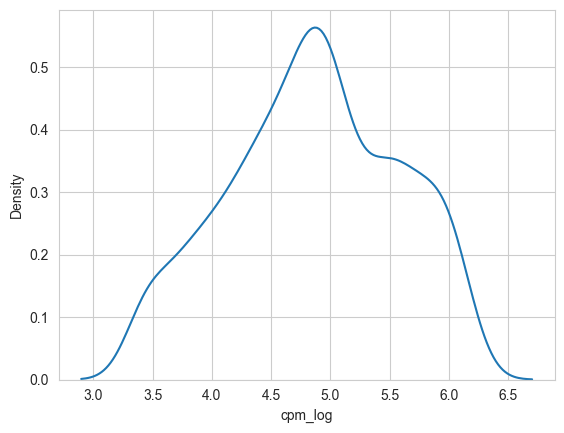

In [30]:
sns.kdeplot(data=validate_df, x='cpm_log')

В целом по границам и по среднему распределения похожи

## validate_answers_df

Интересно, можно ли упростить себе задачу?

In [31]:
validate_answers_df.corr()

,at_least_one,at_least_two,at_least_three
at_least_one,1.000000,0.962787,0.918242
at_least_two,0.962787,1.000000,0.986001
at_least_three,0.918242,0.986001,1.000000


Очень сильная корреляция...  
Это нам точно поможет

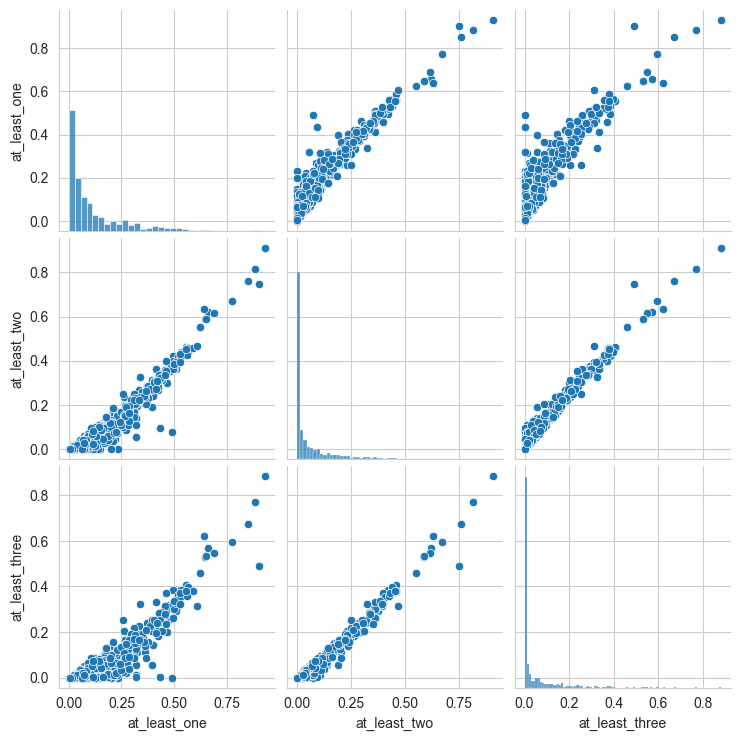

In [32]:
sns.pairplot(validate_answers_df)

Явно можно свести задачу к определению at_least_one, а остальные 2 значения с большой точностью можно линейной регрессией определить

Дополнительно можно сделать классификацию чтобы сразу браковать те объявления, которые будут выдавать нули из-за малой длительности

## users

В принципе таблица может быть интересна для классификации / кластеризации пользователей

Посмотрим, есть ли пропуски

In [33]:
users_df['sex'].value_counts()

sex
1    14515
2    13224
0       30
Name: count, dtype: int64

In [34]:
sum(users_df['age'] == 0)

2180

Пропуски есть, если будем работать с этой таблицей надо будет не забыть их обработать